# Speech Recognition
____
Performs speech recognition on the LibriSpeech dataset. Uses an end-to-end model based of Baidu's Deep Speech 2.

# Load the LibriSpeech Dataset
The LibriSpeech dataset consists of folders nested two deep, the inner folders containing a text file, each line a different utterance, and the associated utterances as FLAC files.

The dataset is located at http://www.openslr.org/12/.

Once the full dataset is downloaded, I will need to modify this. It just uses the dev-clean preview.

In [1]:
import os

librispeech_dir = "/Users/Noah/Downloads/LibriSpeech/dev-clean"

if not os.path.exists(librispeech_dir):
    raise OSError("LibriSpeech directory not found")
    

directories = [os.path.join(librispeech_dir, d) for d in os.listdir(librispeech_dir) 
               if os.path.isdir(os.path.join(librispeech_dir, d))]

audiofiles = []

for directory in directories:
    sub_directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        
    for sub_directory in sub_directories:
        trans_file = open(os.path.join(directory, sub_directory) 
                          + "/" + os.path.basename(directory) + "-" + sub_directory + ".trans.txt", 'r')
        
        for line in trans_file:
            parts = line[:-1].split(" ", 1)
            
            filename = os.path.join(directory, sub_directory) + "/" + parts[0] + ".flac"
            text = parts[1]
            
            audiofiles.append((filename, text))

# Convert the FLAC files to visual representations
This converts the FLAC files into a visual spectogram, scaled by log(1+x).

In [2]:
import librosa
import numpy as np

spectrograms_and_text = []
sample_rate = 16000
window_size = .02 # seconds
window_stride = .01 # seconds

for audiofile, text in audiofiles:
    
    time_series, _ = librosa.load(audiofile, sr=sample_rate)
    n_fft = int(sample_rate * window_size)
    window_length = n_fft
    hop_length = int(sample_rate * window_stride)
                  
    stft = librosa.core.stft(time_series, n_fft=n_fft, hop_length=hop_length, win_length=window_length)
    spectrogram, phase = librosa.magphase(stft)
    spectrogram = np.log1p(spectrogram)
                      
    spectrograms_and_text.append((spectrogram, text))

This is what the log-scaled spectogram of our first audio file looks like:

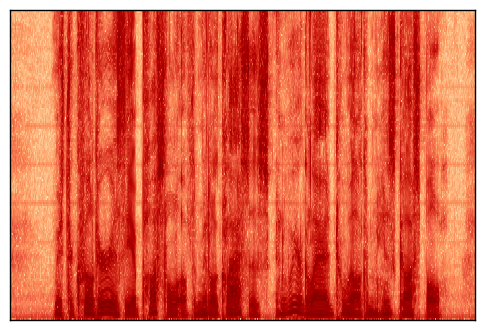

MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL


In [22]:
import matplotlib.pyplot as plt
from IPython.display import Audio
time_series, sampling_rate = librosa.load(audiofiles[0][0])

# Show spectrogram
librosa.display.specshow(librosa.logamplitude(spectrograms_and_text[0][0], ref_power=np.max), fmax=8000)
plt.show()

# Show text
print(audiofiles[0][1])

# Display audio
Audio(time_series, rate=sampling_rate)

# Format Data
Split the data into training and validation sets. Convert the input strings to their associated indeces. Split the data up into batches of similar length, and pad them all to the length of the longest one. Defines two generators to return the batches.

In [4]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ' _"

letter_to_index = dict()
for i in range(0, len(alphabet)):
    letter_to_index[alphabet[i]] = i
    
index_to_letter = dict()
for i in range(0, len(alphabet)):
    index_to_letter[i] = alphabet[i]

In [5]:
def spectogram_length(l):
    return l[0].shape[1]

train_end_index = round(len(spectrograms_and_text) * 0.7)
train_spectrogram_text = spectrograms_and_text[:train_end_index]
validation_spectrogram_text = spectrograms_and_text[train_end_index:]

train_spectrogram_text = sorted(train_spectrogram_text, key=spectogram_length, reverse=True)
validation_spectrogram_text = sorted(validation_spectrogram_text, key=spectogram_length, reverse=True)

In [20]:
from math import ceil

batch_size = 20
val_batch_size = 100

num_batches = int(len(train_spectrogram_text)/batch_size)
num_val_batches = int(len(validation_spectrogram_text)/val_batch_size)

train_batches = []
validation_batches = []

def create_batch(spectrogram_text, size):
    
    spectrograms = []
    indeces = []
    input_lengths = []
    output_lengths = []
    
    spec_length = spectogram_length(spectrogram_text[0])
    output_length = max([len(text) for (spectrogram, text) in spectrogram_text])
    
    # Pad all the spectrograms and text to the largest lengths in the batch
    for (spectrogram, text) in spectrogram_text:
        
        output_lengths.append(len(text))
        input_lengths.append(ceil(spectrogram.shape[1]/4))
        
        padded_spectrogram = np.pad(spectrogram, ((0,0),(0, spec_length - spectrogram.shape[1])), 'constant')
        padded_spectrogram = np.transpose(padded_spectrogram)
        spectrograms.append(padded_spectrogram)
        
        index = []
        for i in range(0, output_length):
            if i < len(text):
                index.append(letter_to_index[text[i]])
            else:
                index.append(len(alphabet) - 1)
        
        indeces.append(index)
    
    # For some reason, Keras likes all these to have extra dimension 1
    np_spectrograms = np.expand_dims(np.asarray(spectrograms), axis=3)
    np_indeces = np.asarray(indeces)
    np_input_lengths = np.expand_dims(np.asarray(input_lengths), axis=1)
    np_output_lengths = np.expand_dims(np.asarray(output_lengths), axis=1)
    
    inputs = {'input_spectrogram': np_spectrograms,
              'input_labels': np_indeces,
              'input_length': np_input_lengths,
              'label_length': np_output_lengths}
    
    outputs = {'ctc': np.zeros([size])}
    
    return (inputs, outputs)

# Loop over batches, padding each one to the same size
for i in range(0, num_batches):  
    batch = create_batch(train_spectrogram_text[i * batch_size:(i+1) * batch_size], batch_size)
    train_batches.append(batch)

for i in range(0, num_val_batches):
    batch = create_batch(validation_spectrogram_text[i * val_batch_size:(i+1) * val_batch_size], val_batch_size)
    validation_batches.append(batch)

import random

# Two generators that return the next batch.
# For training, use SortaGrad: the first epoch, return longest batches first.
# After that, return random batches. Helps minimize CTC errors on small early inputs.
def next_batch():
    batch_num = 0
    while batch_num < num_batches:
        yield train_batches[batch_num]
        batch_num += 1
    while True:
        yield random.choice(train_batches)
    
def next_validation_batch():
    while True:
        yield random.choice(validation_batches)

# Build the Network Architecture
The network takes in audio spectrograms, applies 2 2D Convolutional layers, feeds the result into 3 GRU recurrent layers, then applies a time-distributed fully connected softmax layer. It uses CTC loss on the output sequence. Batch normalization is used throughout. The convolutional layers stride over time to shorten the number of timesteps for the RNN.

To Test on Validation Data:
- Try out 1D Convolutions
- Try ReLU 20 on the convolutional layers as in the original paper
- See if adding Dropout on top of BatchNorm helps throughout
- Try different weight initializations
- Test convolutional filter sizes - these seem a little big

Model is based off the Baidu Deep Speech 2 architecture: https://arxiv.org/abs/1512.02595. Some changes will have to be made when I get access to GPUs. 

In [7]:
from keras.models import Model
from keras.layers import Input

# Model parameters
spectrogram_height = 161
spectrogram_input_size = (None, spectrogram_height, 1) #(width, height, channels)

# Initial Model input
input_spectrogram = Input(name='input_spectrogram', shape=spectrogram_input_size)

Using TensorFlow backend.


### Convolutional Layers

Two 2D Convolutional layers. The first one uses slightly larger convolutions. Both have a stride of 2 over the time dimension. In the Baidu paper, 2D produces better results than 1D convolutions.

In [8]:
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

nf = 32 # Number of filters
a = 'relu' # Activation function
bm = 'same' # Border mode

conv1 = Convolution2D(nf, 41, 11, activation=a, subsample=(2, 2), bias=False, border_mode=bm, name='conv1')(input_spectrogram)
batchnorm1 = BatchNormalization(name="batchnorm1", mode=2)(conv1)
conv2 = Convolution2D(nf, 21, 11, activation=a, subsample=(2, 1), bias=False, border_mode=bm, name='conv2')(batchnorm1)
batchnorm2 = BatchNormalization(name="batchnorm2", mode=2)(conv2)

model1 = Model(input=[input_spectrogram], output=[batchnorm2])
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_spectrogram (InputLayer)   (None, None, 161, 1)  0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, None, 81, 32)  14432       input_spectrogram[0][0]          
____________________________________________________________________________________________________
batchnorm1 (BatchNormalization)  (None, None, 81, 32)  128         conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, 81, 32)  236544      batchnorm1[0][0]                 
___________________________________________________________________________________________

### Reshape Layer

This will reshape CNN output (width, height, num filters) to GRU input (width, height * num filters)

This method is TensorFlow specific - to change to Theano backend, would need Theano's flatten function.

In [9]:
from tensorflow import shape, reshape
from keras.layers import Lambda

input_height = ceil(spectrogram_height / 2)

def reshapeCNNtoRNN(x):
    previous_dimensions = shape(x)
    return reshape(x, [previous_dimensions[0], -1, int(input_height * nf)])

def reshapeCNNtoRNN_output_shape(input_shape):
    shape = list(input_shape)
    time_dim = shape[1]
    assert shape[2] == input_height
    assert shape[3] == nf
    return (None, time_dim, int(input_height * nf))

reshaped = Lambda(reshapeCNNtoRNN, output_shape=reshapeCNNtoRNN_output_shape, name="reshape")(batchnorm2)

model2 = Model(input=[input_spectrogram], output=[reshaped])
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_spectrogram (InputLayer)   (None, None, 161, 1)  0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, None, 81, 32)  14432       input_spectrogram[0][0]          
____________________________________________________________________________________________________
batchnorm1 (BatchNormalization)  (None, None, 81, 32)  128         conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, 81, 32)  236544      batchnorm1[0][0]                 
___________________________________________________________________________________________

### Recurrent Layers
This uses the GRU recurrent cell, which shows similar results to an LSTM and slightly faster training. Three layers of bidirectional GRU's, each with a hidden size of 512.

In [10]:
from keras.layers.recurrent import GRU
from keras.layers import merge

dim = 512
merge_mode = 'sum'

gru1_forward = GRU(dim, return_sequences=True, name='gru1_forward')(reshaped)
gru1_backward = GRU(dim, return_sequences=True, go_backwards=True, name='gru1_backward')(reshaped)
gru1 = merge([gru1_forward, gru1_backward], mode=merge_mode, name='gru1')

batchnorm_gru1 = BatchNormalization(name="batchnorm_gru1", mode=2)(gru1)

gru2_forward = GRU(dim, return_sequences=True, name='gru2_forward')(batchnorm_gru1)
gru2_backward = GRU(dim, return_sequences=True, go_backwards=True, name='gru2_backward')(batchnorm_gru1)
gru2 = merge([gru2_forward, gru2_backward], mode=merge_mode, name='gru2')

batchnorm_gru2 = BatchNormalization(name="batchnorm_gru2", mode=2)(gru2)

gru3_forward = GRU(dim, return_sequences=True, name='gru3_forward')(batchnorm_gru2)
gru3_backward = GRU(dim, return_sequences=True, go_backwards=True, name='gru3_backward')(batchnorm_gru2)
gru3 = merge([gru3_forward, gru3_backward], mode=merge_mode, name='gru3')

batchnorm_gru3 = BatchNormalization(name="batchnorm_gru3", mode=2)(gru3)

model3 = Model(input=[input_spectrogram], output=[batchnorm_gru3])
model3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_spectrogram (InputLayer)   (None, None, 161, 1)  0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, None, 81, 32)  14432       input_spectrogram[0][0]          
____________________________________________________________________________________________________
batchnorm1 (BatchNormalization)  (None, None, 81, 32)  128         conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, 81, 32)  236544      batchnorm1[0][0]                 
___________________________________________________________________________________________

### Fully Connected Layer
This is just one time distributed softmax over the 29 possible outputs. The last of these represents a blank for CTC.

In [11]:
from keras.layers import TimeDistributed
from keras.layers.core import Dense

output_size = len(alphabet)
y_pred = TimeDistributed(Dense(output_size, activation='softmax', name='y_pred'))(batchnorm_gru3)

model4 = Model(input=[input_spectrogram], output=[y_pred])
model4.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_spectrogram (InputLayer)   (None, None, 161, 1)  0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, None, 81, 32)  14432       input_spectrogram[0][0]          
____________________________________________________________________________________________________
batchnorm1 (BatchNormalization)  (None, None, 81, 32)  128         conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, 81, 32)  236544      batchnorm1[0][0]                 
___________________________________________________________________________________________

### CTC Layer

(Note: Warp-CTC performs its own softmax)

Because CTC is just a function here, and keras loss functions can't accept multiple arguments, CTC cost is just implemented as the final layer, and the loss function will just point to that last layer

In [12]:
from keras.backend import ctc_batch_cost

input_labels = Input(name='input_labels', shape=(None,))
input_length = Input(name='input_length', shape=[1])
label_length = Input(name='label_length', shape=[1])

def ctc_function(args):
    y_true, y_pred, input_length, label_length = args
    return ctc_batch_cost(y_true, y_pred, input_length, label_length)

ctc_loss = Lambda(ctc_function, output_shape=(1,), name = 'ctc')([input_labels, y_pred, input_length, label_length])

model = Model(input=[input_spectrogram, input_labels, input_length, label_length], output=ctc_loss)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_spectrogram (InputLayer)   (None, None, 161, 1)  0                                            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, None, 81, 32)  14432       input_spectrogram[0][0]          
____________________________________________________________________________________________________
batchnorm1 (BatchNormalization)  (None, None, 81, 32)  128         conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, 81, 32)  236544      batchnorm1[0][0]                 
___________________________________________________________________________________________

# Compile the Model. Train it.

The model uses the Adam optimizer with default values. It saves the model and weights to a file every 5 epochs. If the validation accuracy stops increasing for three epochs, the model will stop training to avoid overfitting.

Once I get access to GPU's, I may need to change some of these values.

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

adam_optimizer = Adam()
model.compile(loss={'ctc': lambda input_labels, y_pred: y_pred}, optimizer=adam_optimizer)

train_generator = next_batch()
validation_generator = next_validation_batch()

callbacks = [ModelCheckpoint("model", monitor='val_acc', verbose=1, period=5),
             EarlyStopping(monitor='val_acc', patience=2)]

num_epochs = 100
model.fit_generator(train_generator, num_batches, num_epochs, verbose=2, callbacks=callbacks,
                    validation_data=validation_generator, nb_val_samples=1)

KeyboardInterrupt: 

### Todo:
- Once I download the full dataset, fix the data loader.
- Add a way to test the model on an audiofile once I get a model trained. Should just require using model.predict().
- Once I do that, add a language model to re-score the n most likely CTC outputs. Can probably just use a library for this.
- Perform a lot of hyperparameter tweaking mentioned above in the model description.